# Importing Libraries

In [35]:
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
from darts.metrics import mae

# --- CONFIGURATION ---

In [36]:
DATA_PATH = "../data/FNCL.6.5.xlsx" 
DATE_COL = 'Dates'
VALUE_COL = 'FNCL 6.5 2022 FL Mtge' 
ROLLING_WINDOW = 30

# --- DATA LOADING AND CLEANING ---

In [37]:
def load_and_clean_generic(path, date_col_name, value_col_name):
    """Loads and cleans data using flexible column names."""
    
    try:
        df = pd.read_excel(path) 
    except FileNotFoundError:
        print(f"Error: File not found at {path}. Please check your data directory.")
        return None

    df.columns = df.columns.str.strip()
    
    # Handle the specific case of the FNCL file where columns are known
    if date_col_name not in df.columns or value_col_name not in df.columns:
         print("Warning: Named columns not found. Assuming Date is first column, Value is second.")
         if len(df.columns) >= 2:
             df = df.iloc[:, :2].copy()
             df.columns = [date_col_name, value_col_name]
         else:
             raise ValueError("File is too malformed.")
    else:
         df = df[[date_col_name, value_col_name]].copy()
         
    df[date_col_name] = pd.to_datetime(df[date_col_name], errors='coerce')
    df.set_index(date_col_name, inplace=True)
    df[value_col_name] = pd.to_numeric(df[value_col_name], errors='coerce')
    df.dropna(subset=[value_col_name], inplace=True)
    df = df[[value_col_name]].sort_index()

    if not df.index.is_unique:
        df = df.groupby(df.index).mean()
        
    df[value_col_name] = df[value_col_name].interpolate(method='linear')
    
    return TimeSeries.from_dataframe(df, value_cols=value_col_name, freq='D')

# --- EXPLORATION ---

Loaded Time Series with 950 time steps.


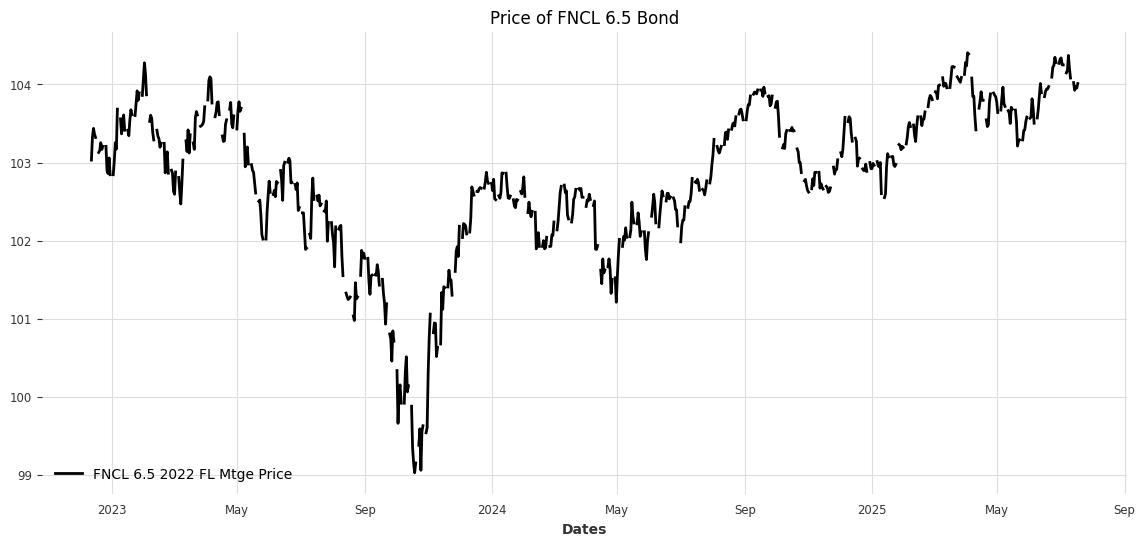

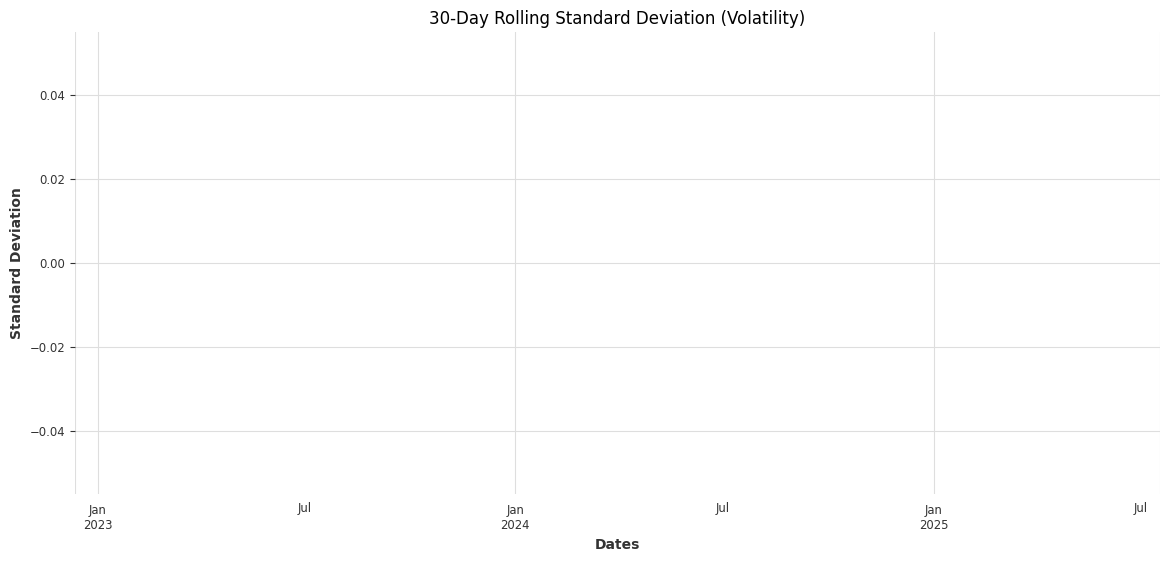


Average Absolute Daily Change: 0.0823%
Maximum Daily Change: 0.7098%

✅ Data appears volatile enough.


C:\Users\user\AppData\Local\Temp\ipykernel_1980\2350735532.py:32: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_change = series_df[VALUE_COL].pct_change().abs() * 100


In [ ]:
series = load_and_clean_generic(DATA_PATH, DATE_COL, VALUE_COL)

if series:
    print(f"Loaded Time Series with {len(series)} time steps.")
    
    plt.figure(figsize=(14, 6))
    series.plot(label=f"{VALUE_COL} Price", title=f"Price of FNCL 6.5 Bond")
    plt.show()

    try:
        tmp = series.pd_series()  # older/newer versions may have this
        series_df = tmp.to_frame() if hasattr(tmp, "to_frame") else pd.DataFrame(tmp)
    except AttributeError:
        try:
            tmp = series.pd_dataframe()
            series_df = tmp if isinstance(tmp, pd.DataFrame) else pd.DataFrame(tmp)
        except AttributeError:
            series_df = series.to_dataframe()

    volatility = series_df[VALUE_COL].rolling(window=ROLLING_WINDOW).std()
    
    plt.figure(figsize=(14, 6))
    volatility.plot(title=f'{ROLLING_WINDOW}-Day Rolling Standard Deviation (Volatility)')
    plt.ylabel("Standard Deviation")
    plt.show()

    daily_change = series_df[VALUE_COL].pct_change().abs() * 100
    print(f"\nAverage Absolute Daily Change: {daily_change.mean():.4f}%")
    print(f"Maximum Daily Change: {daily_change.max():.4f}%")
    
    if daily_change.mean() > 0.05:
        print("\n Data appears volatile enough.")
    else:
        print("\n Data is extremely stable (as expected for this bond).")